In [32]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 1,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()



Sim time: 0.0, Dt: 0.17 (days)
sticking: 4, sliding: 0, open: 0


TypeError: super(type, obj): obj must be an instance or subtype of type

In [17]:
rhs = model.linear_system[1]

In [4]:
# mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
#     load_data(f"../stats/{model.simulation_name()}.json"), 2
# )
# model.linear_system = mat, rhs
# model.bmat.mat = mat

In [7]:
abs(rhs).max()

0.009393939394109884

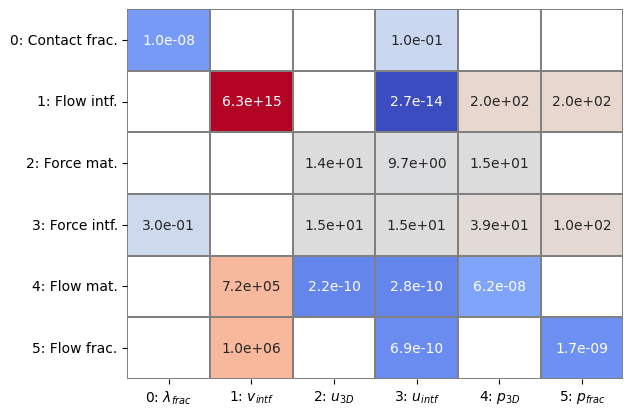

In [18]:
J = model.bmat[:]
J.plot_max()

Solve  took: 0.01
True residual: 2.2206071803709337e-11
PETSc Converged Reason: 2


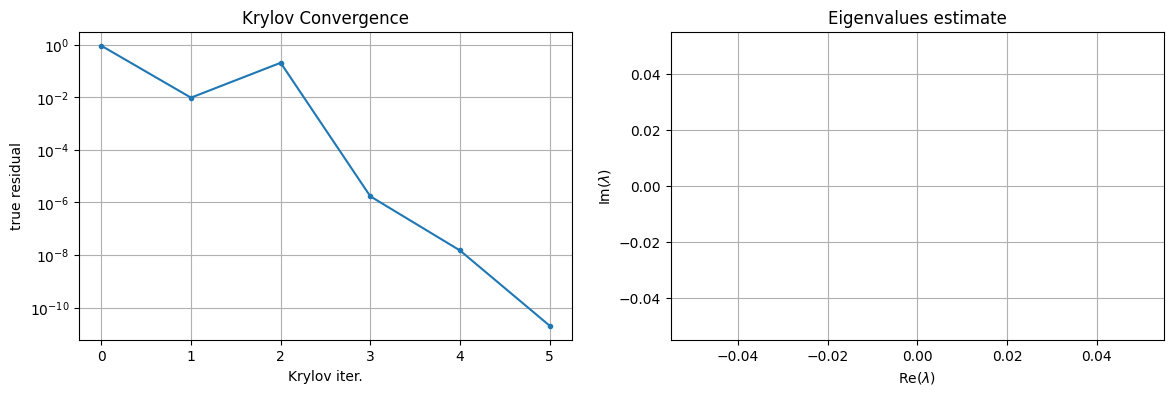

In [21]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="gmres",
        rtol=1e-8,
        pc_side="right",
        # ksp="richardson",
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat
                    * 1,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

Solve  took: 0.02
True residual: 7.358305671005483e-12
PETSc Converged Reason: 2


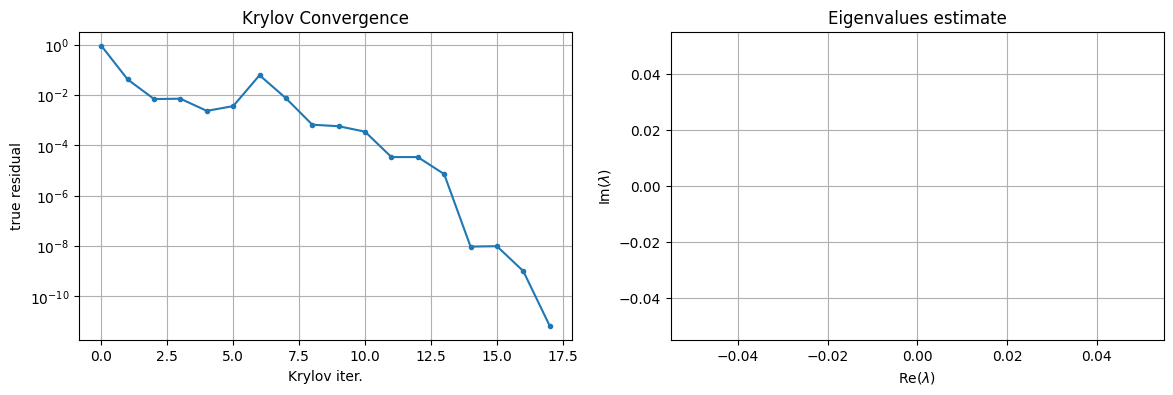

In [26]:
solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp='richardson',
        preconditioner=FieldSplitScheme(
            # factorization_type='full',
            groups=[2, 3],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2, 3]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model),
            ),
            invertor_type="physical",
            invertor=lambda bmat: make_fs_analytical(
                model, bmat, p_mat_group=4, p_frac_group=5
            ).mat
            * 1,
            complement=FieldSplitScheme(
                # factorization_type='full',
                groups=[4, 5],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[4, 5]].mat, dim=model.nd),
            ),
        ),
    ),
)

Solve  took: 0.0
True residual: 4.69004276008467e-12
PETSc Converged Reason: 2


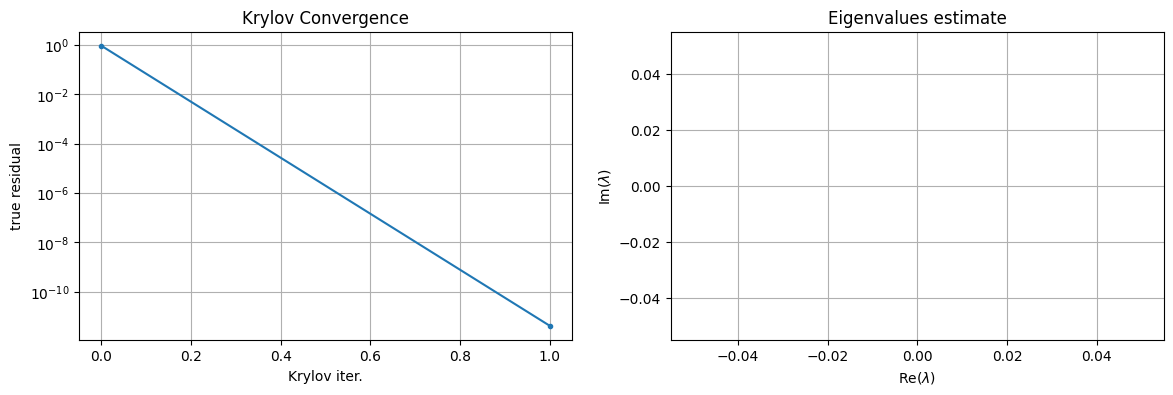

In [30]:
solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp='richardson',
        preconditioner=FieldSplitScheme(
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat * 0,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)